# Imports, Functions and Variables
Ricardo Crespo, Miguel Melro

In [1]:
# Jupyter Notebook can  be used. Restart Kernel and run.
# This work is licensed under the Creative Commons Attribution-NonCommercial-NoDerivs (CC BY-NC-ND 4.0) License
# and is subject to patent application regulations.
# Author: João da Silva Pereira (joao.pereira@ipleiria.pt)

# Clear all variables from the workspace
#%reset -f

import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow import reshape
from keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from openpyxl import load_workbook

import json
from datetime import datetime, timedelta
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import OrderedDict

K.clear_session()

WMethod = 1 # see the argument of getInitialier(). 1 is PSJ and <> of 1 is a random method. Should be a number between 1 and 15.
NLayer_ini = 1 # Inicial hidden layer number 
NLayermax = 2 #show -1 HLayers than this number
deltaNLayer = 1 # Delta increment for hidden layers
NEpochs = 100 # Epochs number alterado de 11 para 100
n_folds = 10  # Folders number. Should be higher than 2 
N_neuronio = 64 # Neurons number
Batch_len = 5   # Batch Size number

Xinput = 10000 # Input number 
Youtput = 3  # Output number
Namostra= 16  # Samples number for test validation

#Funções adicionadas para o data fetch do dataset de percipitação
def count_how_many_occurrences_of_each_value(arr):
    arr = np.ravel(arr)
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    ordered_counts = OrderedDict(sorted(counts.items()))
    return ordered_counts

def list_dataset_folders():
    folders = []
    folder_path = os.getcwd()
    folder_path = os.path.join(folder_path, "datasets")
    for name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, name)):
            if name.endswith("dataset"):
                folders.append(name)
    return folders


def resize_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Resize the image to 100x100 pixels
    resized_image = image.resize((100, 100))

    # Return the resized image
    return resized_image

#Ids das estações
ids = np.array([1240610, 1210718, 1210702, 1200562, 6212124, 1200575, 1200570, 1200571, 1240903, 1210734, 1210707, 1200558, 1200554, 1210683, 7240919, 1210770, 1240566, 1240675])

# Change Normalization Approach

In [9]:
import os
import json
# Função usada para alterar as classes para as novas classes de normalização
def processar_e_atualizar_arquivos_json(caminho_da_pasta):
    # Percorre todos os arquivos na pasta especificada
    for nome_do_arquivo in os.listdir(caminho_da_pasta):
        print(f"Ficheiro: {nome_do_arquivo}")
        if nome_do_arquivo.endswith('.json'):
            caminho_completo = os.path.join(caminho_da_pasta, nome_do_arquivo)
            
            with open(caminho_completo, 'r') as arquivo_json:
                dados = json.load(arquivo_json)
            
            for data, horarios in dados.items():
                for hora, valor in horarios.items():
                    # Substitui os valores conforme as regras
                    if valor >= 0 and valor < 2:
                        dados[data][hora] = 0  # Substitui por 0 para avisos verde
                    elif valor >= 2 and valor <= 4:
                        dados[data][hora] = 1  # Substitui por 1 para avisos amarelo-esverdiado
                    elif valor > 4:
                        dados[data][hora] = 2  # Substitui por 2 para avisos amarelo
            # Reescreve o arquivo com os novos valores
            with open(caminho_completo, 'w') as arquivo_json:
                json.dump(dados, arquivo_json, indent=4)
            
caminho_da_pasta = 'datasets/dataset/precipitation'
processar_e_atualizar_arquivos_json(caminho_da_pasta)

Ficheiro: 1200554.json
Ficheiro: 1200558.json
Ficheiro: 1200562.json
Ficheiro: 1200570.json
Ficheiro: 1200571.json
Ficheiro: 1200575.json
Ficheiro: 1210683.json
Ficheiro: 1210702.json
Ficheiro: 1210707.json
Ficheiro: 1210718.json
Ficheiro: 1210734.json
Ficheiro: 1210770.json
Ficheiro: 1240566.json
Ficheiro: 1240610.json
Ficheiro: 1240675.json
Ficheiro: 1240903.json
Ficheiro: 6212124.json
Ficheiro: 7240919.json


# Data Treatment

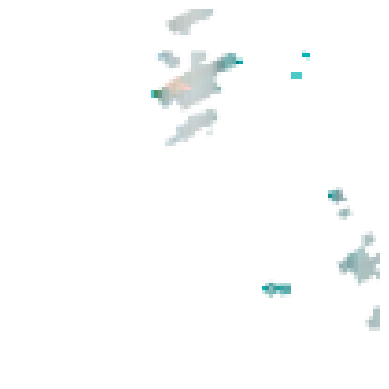

How many of each value in train:
OrderedDict([(0.0, 13), (1.0, 16), (2.0, 10)])
How many of each value in validation:
OrderedDict([(0.0, 7), (1.0, 4), (2.0, 7)])


In [2]:
#Data treatment para o dataset de percipitação
limit_dictionary = {key: 20 for key in range(101)} #para usar mais imagens de chuva, aumentar o valor do limite para cada categoria 
time_difference = 1 #diferença entre a hora da imagem e a hora do valor da chuva

image_size = 100 
counter_dictionary = {key: 0 for key in range(101)}
specific_datasets = list_dataset_folders()
data_array = np.empty(0)
images_array = np.empty((0, image_size, image_size, 4))

np.random.shuffle(specific_datasets)
np.random.shuffle(ids)

#for dataset in specific_datasets:
for stationID in ids:
    currentDir = 'datasets/dataset/precipitation/'+str(stationID)+'.json'
    with open(currentDir) as f:
        # Load the JSON data
        data = json.load(f)
    f.close()
    for date, hours in data.items():
        for hour in hours:
            hora_da_imagem = datetime.strptime(hour, "%H:%M")
            # Subtract one hour
            hora_da_imagem = hora_da_imagem - timedelta(hours=time_difference)
            # Convert back to string
            hora_da_imagem = hora_da_imagem.strftime("%H:%M")
            variable = date + 'T' + hora_da_imagem.replace(':', '') + '.png'  
            value = data[date][hour]
    
            if not os.path.exists('datasets/dataset/images/'+str(stationID)+'/'+date+'/'+variable):
                continue  # Skip the current iteration if the image doesn't exist
            if counter_dictionary[value] < limit_dictionary[value]:
                counter_dictionary[value] += 1
                data_array = np.append(data_array, value)
                image = resize_image('datasets/dataset/images/'+str(stationID)+'/'+date+'/'+variable)
                img_np = np.array(image)
                image.close()
                images_array = np.append(images_array,[img_np], axis=0) #NAO TIRAR PARENTESIS RETOS!!!!!!!!!!!!!!
                
                """# Duplicar imagens da classe(s) minoritária(s) (classe 1 e 2) Abordagem 3
                if value == 2:
                    for _ in range(177):  # Ajustar o número de duplicações para balancear com a classe 0
                        data_array = np.append(data_array, value)
                        images_array = np.append(images_array, [img_np], axis=0)
                elif value == 1:
                    for _ in range(50):  # Ajustar o número de duplicações para balancear com a classe 0
                        data_array = np.append(data_array, value)
                        images_array = np.append(images_array, [img_np], axis=0)"""

perm = np.random.permutation(len(data_array))
images_array, data_array = images_array[perm], data_array[perm]

train_images, test_images, train_labels, test_labels = train_test_split(images_array, data_array, test_size=0.3, random_state=2) 

train_images = tf.keras.utils.normalize(train_images, axis=1)
test_images = tf.keras.utils.normalize(test_images, axis=1)

#Print Imagem
plt.imshow(train_images[0])
plt.axis('off')  # Disable axis
plt.show()  

print("How many of each value in train:")
print(count_how_many_occurrences_of_each_value(train_labels))
print("How many of each value in validation:")
print(count_how_many_occurrences_of_each_value(test_labels))

# Initialize inputs tensors/arrays for Training and testing
x_train = train_images[:6*Namostra, :100, :100] 
x_test = test_images[:Namostra, :100, :100] 

# Initialize ouputs tensors/arrays for Training and testing
y_train = train_labels[:6*Namostra]
y_test = test_labels[:Namostra]


# Model Training

/Users/joe/Dev/EI2425/ProjetoInformatico/MeteoIA24/RicardoCrespo2211047_MiguelMelro2212879-SiteWebMeteoComIA-PrimeiroZip/Network-training/venvteste39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,624 (260.25 KB)

 Trainable params: 66,240 (258.75 KB)

 Non-trainable params: 384 (1.50 KB)

Ini Weight initialization
Method PSJ
[[[0.         0.05614486 0.04449099 0.04767451]
  [0.         0.06451452 0.05323854 0.06344583]
  [0.         0.06573105 0.05468203 0.06696353]
  ...
  [0.08264807 0.0407724  0.03176951 0.04589541]
  [0.05284768 0.04032132 0.03114535 0.04709709]
  [0.03751086 0.04086162 0.03192606 0.04749271]]

 [[0.         0.06661247 0.05520519 0.05120311]
  [0.         0.06610213 0.05460245 0.06579535]
  [0.         0.06754363 0.05835062 0.06424905]
  ...
  [0.05629651 0.05832823 0.04981325 0.04671938]
  [0.02539434 0.05733145 0.04707054 0.04758545]
  [0.0177683  0.03975849 0.0271499  0.04749271]]

 [[0.         0.06430665 0.05190639 0.0632863 ]
  [0.         0.06712458 0.05556369 0.06728638]
  [0.         0.06673247 0.06033595 0.06984257]
  ...
  [0.         0.07515933 0.07167765 0.05871983]
  [0.         0.05624837 0.0518631  0.05251798]
  [0.         0.05655055 0.05114371 0.04755759]]

 ...

 [[0.         0.07142301 0.07410908 0.08198858]
  [0.         0.07173

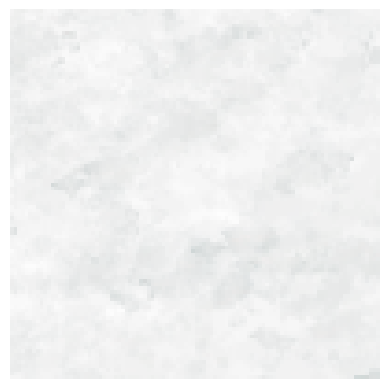

(1, 40000)


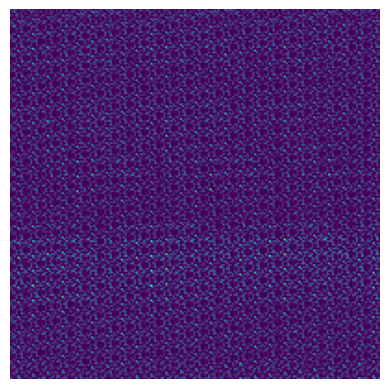

[[-0.00309764 -0.00445275 -0.00394764 ... -0.00194037 -0.0020072
   0.00273257]
 [ 0.01755894  0.00955686  0.00396656 ... -0.00128971 -0.00917547
  -0.00109745]
 [ 0.00480189  0.00192412  0.00802734 ...  0.01204923 -0.00222433
   0.01155894]
 ...
 [ 0.01755894  0.00955686  0.00396656 ... -0.00128971 -0.00917547
  -0.00109745]
 [ 0.00480189  0.00192412  0.00802734 ...  0.01204923 -0.00222433
   0.01155894]
 [-0.00309764 -0.00445275 -0.00394764 ... -0.00194037 -0.0020072
   0.00273257]]
(64, 40000)
End Weight initialization

Hidden Layer =  1

Fold 1

Weights loaded
Epoch 1/100


/Users/joe/Dev/EI2425/ProjetoInformatico/MeteoIA24/RicardoCrespo2211047_MiguelMelro2212879-SiteWebMeteoComIA-PrimeiroZip/Network-training/venvteste39/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamax', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/joe/Dev/EI2425/ProjetoInformatico/MeteoIA24/RicardoCrespo2211047_MiguelMelro2212879-SiteWebMeteoComIA-PrimeiroZip/Network-training/venvteste39/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8992 - loss: 0.2013 - precision: 0.8989 - recall: 0.8960
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8990 - loss: 0.2092 - precision: 0.8984 - recall: 0.8933 - val_accuracy: 0.8125 - val_loss: 0.3742 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8790 - loss: 0.2287 - precision: 0.8790 - recall: 0.8790
Epoch 2: val_accuracy did not improve from 0.81250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8782 - loss: 0.2304 - precision: 0.8782 - recall: 0.8782 - val_accuracy: 0.7500 - val_loss: 0.3904 - val_precision: 0.8000 - val_recall: 0.7500
Epoch 3/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7497 - loss: 0.5303 - precision: 0.7497 - recall: 0.7497
Epoch 3: val_accuracy did not improve from 0.81250
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

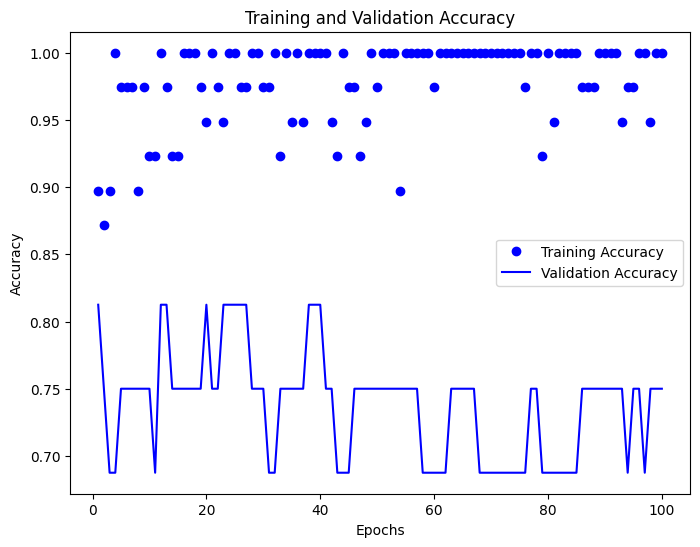

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 4 ] =  1.0000         |  Accuracy Train[ 1 ] =  0.8974
   Accuracy Test[ 100 ] = 0.7500   |  Validation Accuracy Test[ 4 ] =  0.6875   |  Max Valid. Accuracy Test[ 1 ] =  0.8125

Fold 2

Weights loaded
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9835 - loss: 0.0814 - precision: 0.9835 - recall: 0.9835
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9739 - loss: 0.1158 - precision: 0.9739 - recall: 0.9739 - val_accuracy: 0.7500 - val_loss: 2.2441 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9250 - loss: 0.2821 - precision: 0.9250 - recall: 0.9250
Epoch 2: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9303 - loss: 0.2750 - precision: 0.9303 - recall: 0.9303 - val_accuracy: 0.750

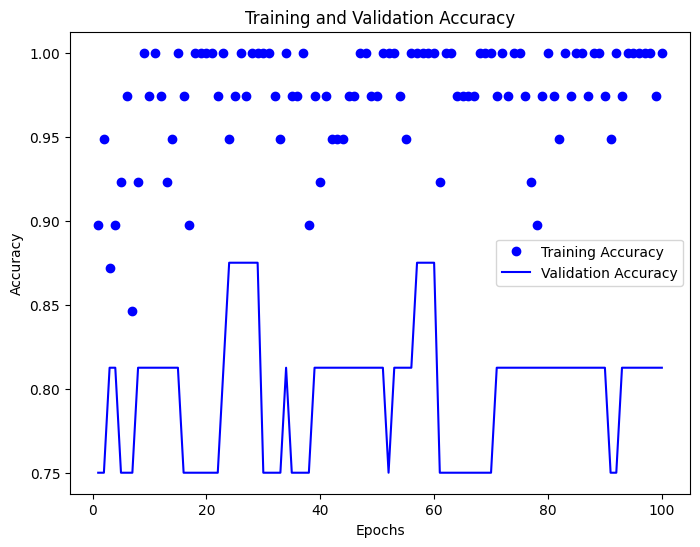

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 9 ] =  1.0000         |  Accuracy Train[ 24 ] =  0.9487
   Accuracy Test[ 100 ] = 0.8125   |  Validation Accuracy Test[ 9 ] =  0.8125   |  Max Valid. Accuracy Test[ 24 ] =  0.8750

Fold 3

Weights loaded
Epoch 1/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9910 - loss: 0.0424 - precision: 0.9910 - recall: 0.9910
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9759 - loss: 0.0905 - precision: 0.9759 - recall: 0.9759 - val_accuracy: 0.7500 - val_loss: 1.1436 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9521 - loss: 0.1708 - precision: 0.9521 - recall: 0.9521
Epoch 2: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9457 - loss: 0.1768 - precision: 0.9457 - recall: 0.9457 - val_accuracy: 0.7

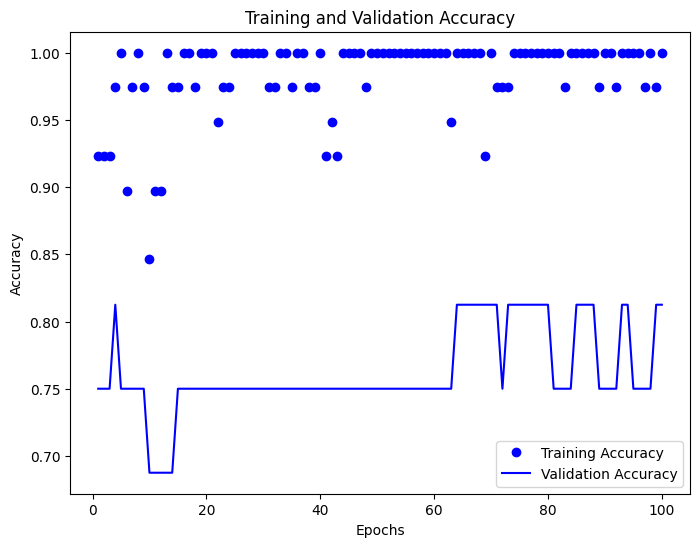

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 5 ] =  1.0000         |  Accuracy Train[ 4 ] =  0.9744
   Accuracy Test[ 100 ] = 0.8125   |  Validation Accuracy Test[ 5 ] =  0.7500   |  Max Valid. Accuracy Test[ 4 ] =  0.8125

Fold 4

Weights loaded
Epoch 1/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9817 - loss: 0.0447 - precision: 0.9817 - recall: 0.9817
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9744 - loss: 0.0568 - precision: 0.9744 - recall: 0.9744 - val_accuracy: 0.7500 - val_loss: 1.4582 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9681 - loss: 0.1081 - precision: 0.9665 - recall: 0.9362
Epoch 2: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9688 - loss: 0.1067 - precision: 0.9673 - recall: 0.9376 - val_accuracy: 0.687

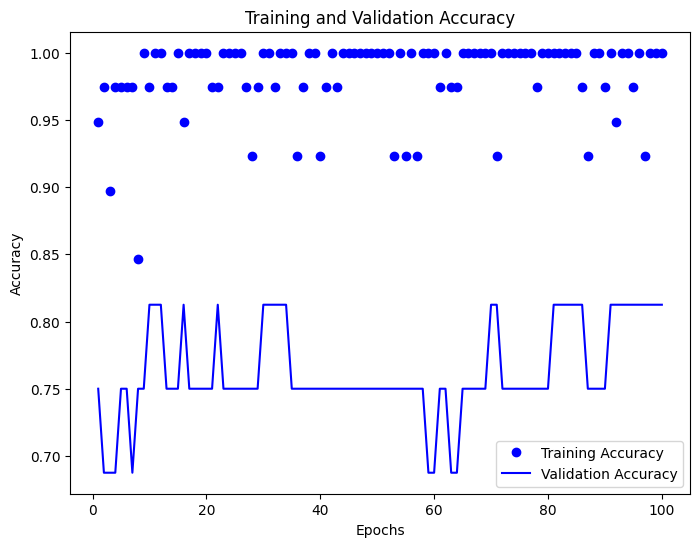

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 9 ] =  1.0000         |  Accuracy Train[ 10 ] =  0.9744
   Accuracy Test[ 100 ] = 0.8125   |  Validation Accuracy Test[ 9 ] =  0.7500   |  Max Valid. Accuracy Test[ 10 ] =  0.8125

Fold 5

Weights loaded
Epoch 1/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9687 - loss: 0.1063 - precision: 0.9687 - recall: 0.9687
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9699 - loss: 0.0987 - precision: 0.9699 - recall: 0.9699 - val_accuracy: 0.7500 - val_loss: 1.3220 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9742 - loss: 0.0640 - precision: 0.9742 - recall: 0.9742
Epoch 2: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9686 - loss: 0.0808 - precision: 0.9686 - recall: 0.9686 - val_accuracy: 0.6

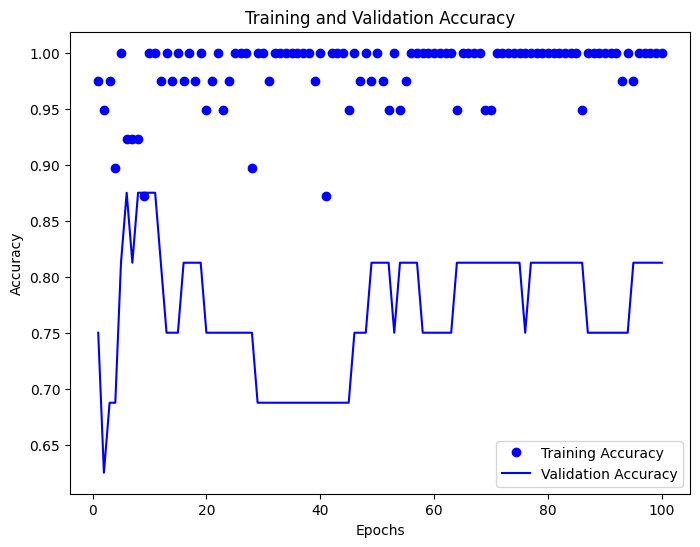

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 5 ] =  1.0000         |  Accuracy Train[ 6 ] =  0.9231
   Accuracy Test[ 100 ] = 0.8125   |  Validation Accuracy Test[ 5 ] =  0.8125   |  Max Valid. Accuracy Test[ 6 ] =  0.8750

Fold 6

Weights loaded
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0292 - precision: 1.0000 - recall: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 1.0000 - loss: 0.0286 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.6875 - val_loss: 1.1204 - val_precision: 0.6875 - val_recall: 0.6875
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9958 - loss: 0.0554 - precision: 0.9958 - recall: 0.9958
Epoch 2: val_accuracy improved from 0.68750 to 0.81250, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9796 -

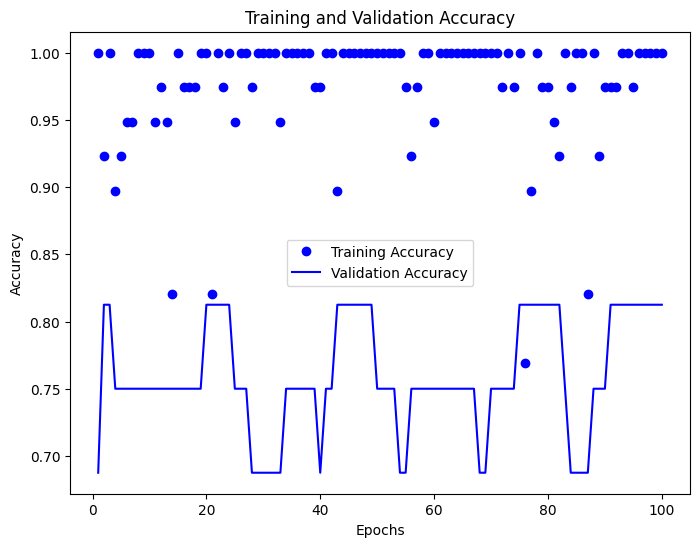

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 1 ] =  1.0000         |  Accuracy Train[ 2 ] =  0.9231
   Accuracy Test[ 100 ] = 0.8125   |  Validation Accuracy Test[ 1 ] =  0.6875   |  Max Valid. Accuracy Test[ 2 ] =  0.8125

Fold 7

Weights loaded
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9066 - loss: 0.2588 - precision: 0.9096 - recall: 0.9066
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9084 - loss: 0.2524 - precision: 0.9138 - recall: 0.9084 - val_accuracy: 0.6250 - val_loss: 0.8687 - val_precision: 0.6154 - val_recall: 0.5000
Epoch 2/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8647 - loss: 0.4821 - precision: 0.8647 - recall: 0.8647
Epoch 2: val_accuracy did not improve from 0.62500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8720 - loss: 0.4617 - precision: 0.8720 - recall: 0.8720 - val_accuracy: 0.375

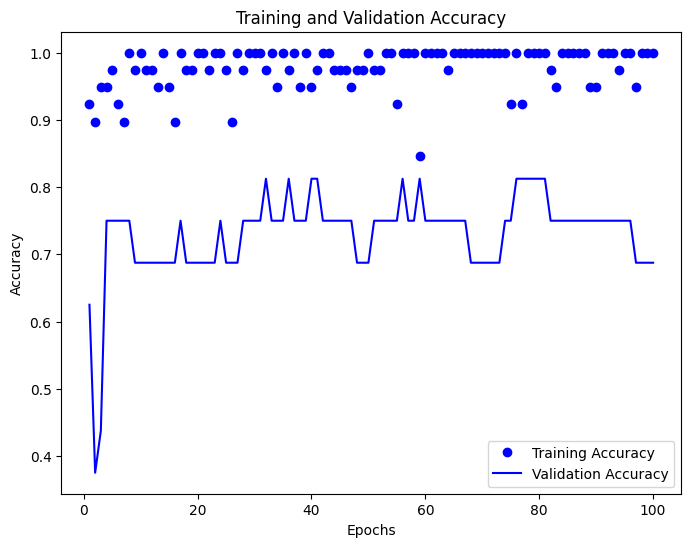

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 8 ] =  1.0000         |  Accuracy Train[ 32 ] =  0.9744
   Accuracy Test[ 100 ] = 0.6875   |  Validation Accuracy Test[ 8 ] =  0.7500   |  Max Valid. Accuracy Test[ 32 ] =  0.8125

Fold 8

Weights loaded
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9776 - loss: 0.0556 - precision: 0.9776 - recall: 0.9776
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9772 - loss: 0.0566 - precision: 0.9772 - recall: 0.9772 - val_accuracy: 0.7500 - val_loss: 1.3666 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8769 - loss: 0.9663 - precision: 0.8769 - recall: 0.8769
Epoch 2: val_accuracy improved from 0.75000 to 0.81250, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8792

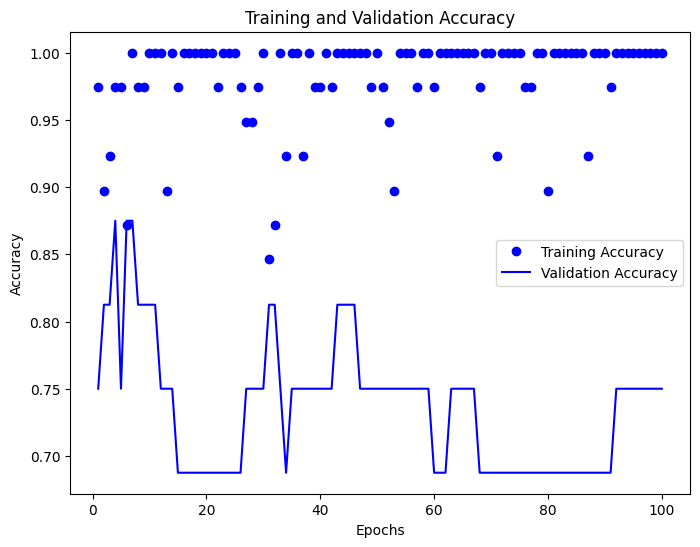

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 7 ] =  1.0000         |  Accuracy Train[ 4 ] =  0.9744
   Accuracy Test[ 100 ] = 0.7500   |  Validation Accuracy Test[ 7 ] =  0.8750   |  Max Valid. Accuracy Test[ 4 ] =  0.8750

Fold 9

Weights loaded
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9655 - loss: 0.0948 - precision: 0.9655 - recall: 0.9655
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9636 - loss: 0.1063 - precision: 0.9636 - recall: 0.9636 - val_accuracy: 0.5000 - val_loss: 2.4599 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0163 - precision: 1.0000 - recall: 1.0000
Epoch 2: val_accuracy did not improve from 0.50000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0165 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.500

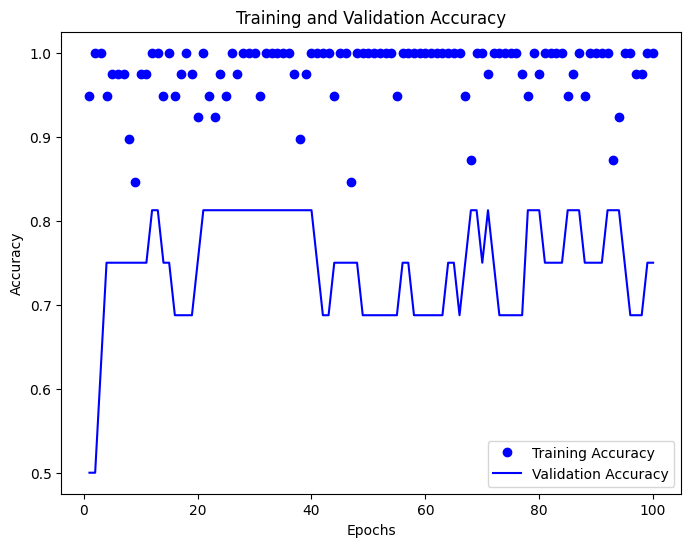

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 2 ] =  1.0000         |  Accuracy Train[ 12 ] =  1.0000
   Accuracy Test[ 100 ] = 0.7500   |  Validation Accuracy Test[ 2 ] =  0.5000   |  Max Valid. Accuracy Test[ 12 ] =  0.8125

Fold 10

Weights loaded
Epoch 1/100
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9849 - loss: 0.0561 - precision: 0.9849 - recall: 0.9849
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model_weights_by_hour/hour_difference_1.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9826 - loss: 0.0641 - precision: 0.9826 - recall: 0.9826 - val_accuracy: 0.7500 - val_loss: 2.3902 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/100
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9179 - loss: 0.3022 - precision: 0.9179 - recall: 0.9179
Epoch 2: val_accuracy did not improve from 0.75000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9363 - loss: 0.2390 - precision: 0.9363 - recall: 0.9363 - val_accuracy: 0.

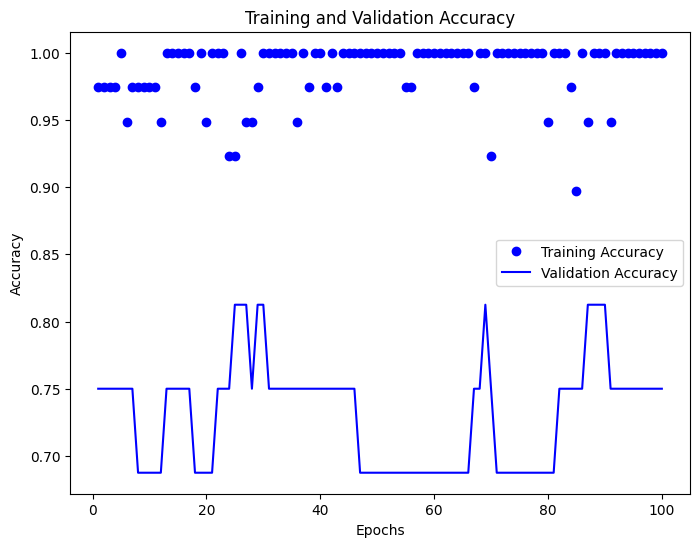

   Accuracy Train[ 100 ] = 1.0000  |  Max Accuracy Train[ 5 ] =  1.0000         |  Accuracy Train[ 25 ] =  0.9231
   Accuracy Test[ 100 ] = 0.7500   |  Validation Accuracy Test[ 5 ] =  0.7500   |  Max Valid. Accuracy Test[ 25 ] =  0.8125


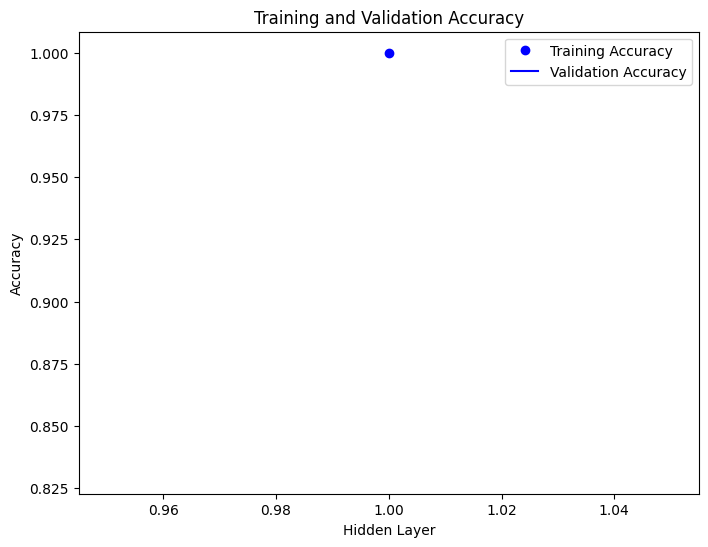



Average of Train Accuracy = 10 folds: 100.00%


Average of Validation Accuracy = 10 folds: 83.12%

train_accuracies_ [1.0]
losses_ [0.0015800000000000002]
accuracies_ [0.83125]
precisions_ [1.0]
val_precisions_ [0.83667]
recalles_ [1.0]
val_recalles_ [0.83125]



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,892,875 (30.11 MB)

 Trainable params: 2,630,787 (10.04 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 5,261,576 (20.07 MB)

In [4]:
# Initialize the model outside the loop
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(100,100,4)))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model1.add(Dropout(0.35)) #alterado de 0.35 para 0.3
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model1.add(Dropout(0.0035)) 
model1.add(Flatten(name='flatten')) 
model1.summary()
# Define the prediction function outside the loop
def predict_with_model(image):
    return model1.predict(image.reshape(1, 100, 100, 4), verbose=0) 
    
#function that implements the PSJ method for the 1st Deep Learning layer (João Silva Pereira)
def PSJmethod():
    z=np.zeros((N_neuronio, Xinput*4))     # reshaping here
    for i in range(0, N_neuronio):
        if i < Youtput:
            soma = np.zeros([100,100,4]) 
            cont = 0
            for n in range(0, len(x_train)):
                if y_train[n] == np.mod(i,Youtput):
                    soma += x_train[n]
                    cont += 1
            soma /= cont 

            # Call the prediction function inside the loop
            soma_r = predict_with_model(soma)
            
            if i == 2:
                #print(soma.shape)
                print(soma)
                # Plot the array as an image
                plt.imshow(soma)
                plt.axis('off')  # Disable axis
                plt.show()

                print(soma_r.shape)
                #print(soma)
                # Plot the array as an image
                plt.imshow(soma_r.reshape(200,200))
                plt.axis('off')  # Disable axis
                plt.show()   
            
            soma = reshape(soma_r, [100*100*4])      # reshaping here 
            s = np.array(soma,dtype="cfloat")
            s = np.fft.fft(s)
            s = np.cos(np.angle(s))+np.sin(np.angle(s))*1j
            s = np.fft.ifft(s)
            z[i] = s.real
        else:
            z[i] = z[np.mod(i,Youtput)]
    return z

#function that implements the PSJ method for the outher Deep Learning layers (João Silva Pereira)
def iniL2(N_neur, inp):
    LastLayerANN=np.zeros((N_neur, inp))
    for r in range(0,N_neur):
        if np.mod(r,inp)==0:
            for k in range(0,inp):  
                for s in range(0,inp): 
                    if k==s:
                        if (r+k)<N_neur:
                            LastLayerANN[r+k][s]=1
    return LastLayerANN

   
# Initialize the seeds within tensorflow for results to be reproducible
# Seeds for NumPy and TensorFlow
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Settings for reproducibility (this may affect performance)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Function that initialize the Weights of the Deep Learning Network for 15 different methods
def getInitialier(WMethod):
    if WMethod==1:
        print("Method PSJ")
        PSJ = PSJmethod()
        print(PSJ)
        print(PSJ.shape)
        return tf.constant_initializer(PSJ), tf.constant_initializer(iniL2(N_neuronio, N_neuronio)), tf.keras.initializers.Ones()
    if WMethod==2:
        print("Method GlorotNormal")
        iniM = tf.keras.initializers.GlorotNormal(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==3:
        print("Method GlorotUniform")
        iniM = tf.keras.initializers.GlorotUniform(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==4:
        print("Method HeNormal")
        iniM = tf.keras.initializers.HeNormal(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==5:
        print("Method HeUniform")
        iniM = tf.keras.initializers.HeUniform(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==6:
        print("Method LecunNormal")
        iniM = tf.keras.initializers.LecunNormal(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==7:
        print("Method LecunUniform")
        iniM = tf.keras.initializers.LecunUniform(seed=seed_value) 
        return iniM, iniM, iniM
    if WMethod==8:
        print("Method Orthogonal")
        iniM = tf.keras.initializers.Orthogonal()
        return iniM, iniM, iniM
    if WMethod==9:
        print("Method RandomNormal")
        iniM = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        return iniM, iniM, iniM
    if WMethod==10:
        print("Method RandomUniform")
        iniM = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        return iniM, iniM, iniM
    if WMethod==11:
        print("Method Identity")
        iniM = tf.keras.initializers.Identity()
        return iniM, iniM, iniM
    if WMethod==12:
        print("Method TruncatedNormal")
        iniM = tf.keras.initializers.TruncatedNormal(mean=0., stddev=0.5) 
        return iniM, iniM, iniM
    if WMethod==13:
        print("Method VarianceScaling")
        iniM = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform') 
        return iniM, iniM, iniM 
    if WMethod==14:
        print("Method Zeros")
        iniM = tf.keras.initializers.Zeros()
        return iniM, iniM, iniM 
    if WMethod==15:
        print("Method Ones")
        iniM = tf.keras.initializers.Ones()
        return iniM, iniM, iniM 

# Create 3 initializer that will train the model
print("Ini Weight initialization")
initializer1, initializer2, initializer10 = getInitialier(WMethod)
print("End Weight initialization")

# Writer do xls to save data
xlsFileName = 'Train_method'+str(WMethod)+' N'+str(N_neuronio)+" MaxHiddenLayer"+str((NLayermax-1))+" "+" MaxFolds"+str(n_folds)+" "+ datetime.now().strftime("%Y %m %d-%H%M%S")+'.xlsx'
writer = pd.ExcelWriter(xlsFileName, engine='openpyxl')

# Create empty arrays
HidenLayeres =[]
train_accuracies_=[]
losses_=[]
accuracies_=[]
val_losses_=[] 
precisions_=[]  
val_precisions_=[]      
recalles_=[]     
val_recalles_=[] 

# Start the program for different configurations
try:   
    # Configuration the the hidden layers
    for n_HL in range(NLayer_ini, NLayermax, deltaNLayer): 
        NLayer=n_HL
        print("")
        print("Hidden Layer = ", NLayer)
        accuracies = []
        train_accuracies = []
        precisions = []
        val_precisions = []
        losses =[]
        val_losses = []
        recalles =[]
        val_recalles = []
        # Configuration of the different folds
        for fold in range(0, n_folds):
            fold += 1
            print(f"\nFold {fold}")
            print("")
                
            x_train_fold = x_train.reshape(-1, 100, 100, 4) 
            y_train_fold =  y_train    
            x_val_fold = x_test
            y_val_fold = y_test
            
            y_train_one_hot = to_categorical(y_train_fold, num_classes=Youtput) 
            y_val_one_hot = to_categorical(y_val_fold, num_classes=Youtput) 
            
            #Callback to save the Keras model or model weights at some frequency
            model_checkpoint = callbacks.ModelCheckpoint(filepath="model_weights_by_hour/hour_difference_" + str(time_difference) + ".weights.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max', save_weights_only=True)

            # Configuration of the Augmentation method
            datagen = ImageDataGenerator(
                rotation_range=5, 
                width_shift_range=0.02,
                height_shift_range=0.02,
                shear_range=0.02,
                zoom_range=0,
                fill_mode='nearest'
            )

            # Deep Learning Network configuration
            model = tf.keras.models.Sequential()   
            
            model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                            input_shape=(100,100,4)))
            model.add(BatchNormalization())
            model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
            model.add(Dropout(0.35)) 
            model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
            model.add(BatchNormalization())
            model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
            model.add(BatchNormalization())
            model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
            model.add(Dropout(0.0035))  
            model.add(Flatten(name='flatten'))           
            Bias_ini = 'zeros'
            model.add(layers.Dense(N_neuronio, activation='relu', kernel_initializer=initializer1, bias_initializer=Bias_ini))
            # Configuration of the quantity of Hidden Layers
            for f in range(1, NLayer+1):
                model.add(layers.Dense(N_neuronio, activation='relu', kernel_initializer=initializer2, bias_initializer=Bias_ini))
            model.add(layers.BatchNormalization())  
            model.add(tf.keras.layers.Dense(Youtput, activation='softmax', kernel_initializer=initializer10))

            # Compile Model
            model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.0055), 
                        loss='categorical_crossentropy',   
                        #metrics=['accuracy'])  
                        metrics=['accuracy', 'precision', 'recall'])  
            
            # Adjust the data generator
            #datagen.fit(x_train_fold)
    
            #, verbose=0
            weights_dir = "model_weights_by_hour/hour_difference_" + str(time_difference) + ".weights.h5"
            #load best weights
            # Nao realizar este passo para comparação entre metodos de inicialização
            try:
                model.load_weights(weights_dir)
                print("Weights loaded")
            except:
                print("Weights not loaded")
                
            history = model.fit(datagen.flow(x_train_fold, y_train_one_hot,batch_size=Batch_len),
                                validation_data=(x_val_fold, y_val_one_hot), epochs=NEpochs, callbacks=[model_checkpoint]) 
            
            # Gets training and validation accuracy results
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']
            
            # Show results
            epochs = range(1, len(train_accuracy) + 1)
            
            plt.figure(figsize=(8, 6))
            plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
    
            r=history #necessary, don't touch ;) 
            n=np.argmax(r.history['accuracy'])
            n_l=np.argmin(r.history['loss'])
            n_val=np.argmax(r.history['val_accuracy'])
            n_vl=np.argmin(r.history['loss'])
            n_p=np.argmax(r.history['precision'])
            n_vp=np.argmax(r.history['val_precision'])
            n_r=np.argmax(r.history['recall'])
            n_vr=np.argmax(r.history['val_recall'])
    

            print("   Accuracy Train[",NEpochs,"] = " + "%.4f" % np.round(r.history['accuracy'][NEpochs-1],4), " |  Max Accuracy Train[",n+1,"] = ",\
                    "%.4f" % np.round(r.history['accuracy'][n],4), "        |  Accuracy Train[",n_val+1,"] = ",\
            "%.4f" % np.round(r.history['accuracy'][n_val],4))

            print("   Accuracy Test[",NEpochs,"] = " + "%.4f" % np.round(r.history['val_accuracy'][NEpochs-1],4), "  |  Validation Accuracy Test[",n+1,"] = ",\
                    "%.4f" % np.round(r.history['val_accuracy'][n],4), "  |  Max Valid. Accuracy Test[",n_val+1,"] = ",\
            "%.4f" % np.round(r.history['val_accuracy'][n_val],4))
            
            train_accuracies.append(np.round(r.history['accuracy'][n],4))
            losses.append(np.round(r.history['loss'][n_l],4))
            accuracies.append(np.round(r.history['val_accuracy'][n_val],4))
            val_losses.append(np.round(r.history['loss'][n_vl],4))
            precisions.append(np.round(r.history['precision'][n_p],4))        
            val_precisions.append(np.round(r.history['val_precision'][n_vp],4))        
            recalles.append(np.round(r.history['recall'][n_r],4))        
            val_recalles.append(np.round(r.history['val_recall'][n_vr],4))        
    
            data = {
                'Epoch' : epochs,
                'Accuracy': np.round(r.history['accuracy'],4),
                'Loss': np.round(r.history['loss'],4),
                'val_accuracy' : np.round(r.history['val_accuracy'],4),
                'val_loss' : np.round(r.history['val_loss'],4),      
                'precision': np.round(r.history['precision'],4),
                'val_precision': np.round(r.history['val_precision'],4),
                'recall': np.round(r.history['recall'],4),
                'val_recall': np.round(r.history['val_recall'],4)
            } 

            df = pd.DataFrame(data)
            
            # Save the DataFrame to the Excel sheet
            sheet_name = f'Fold_{fold}'+f'HLayer_{n_HL}'
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            K.clear_session()

        train_accuracies_.append(np.mean(train_accuracies))
        losses_.append(np.mean(losses))
        accuracies_.append(np.mean(accuracies))
        val_losses_.append(np.mean(val_losses))  
        precisions_.append(np.mean(precisions))  
        val_precisions_.append(np.mean(val_precisions))      
        recalles_.append(np.mean(recalles))      
        val_recalles_.append(np.mean(val_recalles))   

    # Show last plot for all Hidden Layers
    HiddenLayers = range(NLayer_ini, NLayermax, deltaNLayer)    
    plt.figure(figsize=(8, 6))
    plt.plot(HiddenLayers, train_accuracies_, 'bo', label='Training Accuracy')
    plt.plot(HiddenLayers, accuracies_, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Hidden Layer')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    data = {
            'HiddenLayer' : HiddenLayers,
            'Accuracy': train_accuracies_,
            'loss' : losses_,
            'val_accuracy' : accuracies_,
            'val_loss' : val_losses_,
            'precision' : precisions_,
            'val_precision' : val_precisions_,
            'recall' : recalles_,
            'val_recall' : val_recalles_
        }                                            
    df = pd.DataFrame(data) 
    # Save the DataFrame to the Excel sheet
    sheet_name = f'Fold_HL_Average{NLayermax}'
    df.to_excel(writer, sheet_name=sheet_name, index=False)

except KeyboardInterrupt:
    print('\n --- KeyboardInterrupt detected ---')
finally:
    print("")
    mean_Train_accuracy = np.mean(train_accuracies)
    print(f"\nAverage of Train Accuracy = {n_folds} folds: {mean_Train_accuracy * 100:.2f}%")
    print("")
    mean_accuracy = np.mean(accuracies)
    print(f"\nAverage of Validation Accuracy = {n_folds} folds: {mean_accuracy * 100:.2f}%")
    print("")
    print("train_accuracies_",train_accuracies_)
    print("losses_",losses_)
    print("accuracies_",accuracies_)
    print("precisions_",precisions_)  
    print("val_precisions_",val_precisions_)      
    print("recalles_",recalles_)      
    print("val_recalles_",val_recalles_) 
    print("")

    model.summary()
   
    #Close the Writer
    writer.close()#
    
    #move last sheet to first position
    # Carrega o workbook
    wb = load_workbook(xlsFileName)
    last_sheet_name = wb.sheetnames[-1]
    sheet_to_move = wb[last_sheet_name]
    wb.remove(sheet_to_move)
    wb._sheets = [sheet_to_move] + wb._sheets  # Usando _sheets para manipular diretamente a lista de folhas
    wb.save(xlsFileName)

